# Budget Estimate with Simple "Simulation"

This simple notebook compute the simulated survey scenario with a number of variables to estimate the total time taken and budget.

In [14]:
from typing import Tuple, Dict, Optional
import numpy as np
import numba as nb
from numpy import typing as npt
import matplotlib.pyplot as plt


def estimate_total_time_taken(
    n_total_items: int,
    n_participants: int,
    n_items_per_survey: int,
    overhead_time: float=180,
    time_per_item: float=80
) -> Tuple[float, Dict[int, int]]:
    """ Compute the estimated survey budget with respect to the parameters
    """
    # populate "fake" items
    items = np.arange(n_total_items)
    time_taken = 0.
    items_seen = {s: 0 for s in items}  # container for the number of ppl seen
    
    # we assume all surveys are seen by a unique participant
    for j in range(n_participants):
        # populate survey
        survey = np.random.choice(n_total_items, n_items_per_survey, False)
        
        # adding overhead time from questionaires outer the per-item questions
        time_taken += overhead_time
        
        # proceed to the per-item questions
        for item in survey:
            items_seen[item] += 1
            time_taken += time_per_item
    
    # returns the total time and number of unique participants seen per item
    return time_taken, items_seen


# @nb.njit
def split_given_size(
    a: npt.ArrayLike,
    size: int
) -> Tuple[npt.ArrayLike]:
    """ Split array into chunks of equal size with remainder
    https://stackoverflow.com/a/64100245
    """
    return np.split(a, np.arange(size, len(a), size))

  
# @nb.njit
def estimate_total_time_taken_split(
    n_total_items: int,
    n_participants: int,
    n_items_per_survey: int,
    n_items_in_split: int=60,
    n_splits: int=100,
    overhead_time: float=180,
    time_per_item: float=80
) -> Tuple[float, Dict[int, int]]:
    """ compute the estimated survey with respect to the parameters
    """
    assert n_items_in_split > 0 and n_items_in_split <= n_total_items
    assert n_total_items // n_items_in_split > 0

    # populate "fake" items
    items = np.arange(n_total_items)
    
    # seen items stat container
    items_seen_total = {s: 0 for s in items}
    time_taken_total = 0.

    # test with a number of random splits
    for l in range(n_splits):
        # partition items
        np.random.shuffle(items)
        item_bags = split_given_size(items, n_items_in_split)

        # we assume all surveys are seen by a unique participant
        time_taken = 0.
        items_seen = {s: 0 for s in items}  # container for the number of ppl seen
        for j in range(n_participants):
            # populate survey
            # 1. select a bag
            bag = item_bags[np.random.randint(len(item_bags))]
            survey = np.random.choice(bag, n_items_per_survey, False)
            
            # adding overhead time from questionaires outer the per-item questions
            time_taken += overhead_time
            
            # proceed to the per-item questions
            for item in survey:
                items_seen[item] += 1
                time_taken += time_per_item
        
        time_taken_total += time_taken / n_splits
        for s in items:
            items_seen_total[s] += items_seen[s] / n_splits

    # returns the total time and number of unique participants seen per item
    return time_taken_total, items_seen_total


def budget_estimate(
    total_time_taken: float,
    service_fee: float=1.33,
    vat: float=1.2,
    hourly_rate: float=7.5,
    representative_fee: Optional[float]=None
) -> float:
    """ Calculate the budget esimtate with the parameters
    """
    if representative_fee is None:
      representative_fee = 0.

    return (
        ((total_time_taken / 3600. * hourly_rate) + representative_fee) 
        * service_fee 
        * vat
    )

In [2]:
# some variables
n_total_items = 360
n_participants = 500
n_items_per_survey = 17


# do the computations
tt, items_seen = estimate_total_time_taken(
    n_total_items,
    n_participants,
    n_items_per_survey
)
cost = budget_estimate(tt)
median_num_seen = np.median(list(items_seen.values()))


# results printout
print('=============================================================')
print('==[Setup]====================================================')
print('=============================================================')
print(f'The number of unique items: {n_total_items:d}')
print(f'The number of participants: {n_participants:d}')
print(f'The number of items per survey: {n_items_per_survey:d}')
print('=============================================================')
print('==[Result]===================================================')
print('=============================================================')
print(f'Total time taken (est.): {tt / 3600:.2f} hrs')
print(f'Cost (est.): {cost:.2f} pounds')
print(f'Median of the number of unqiue participants per item: {median_num_seen:.2f}')
print('=============================================================')

==[Setup]====================================================
The number of unique items: 360
The number of participants: 500
The number of items per survey: 17
==[Result]===================================================
Total time taken (est.): 213.89 hrs
Cost (est.): 2560.25 pounds
Median of the number of unqiue participants per item: 24.00


In [3]:
# some variables
n_total_items = 360
n_participants = 500
n_items_per_survey = 18
n_items_in_split = 60


# do the computations
tt, items_seen = estimate_total_time_taken_split(
    n_total_items,
    n_participants,
    n_items_per_survey,
    n_items_in_split
)
cost = budget_estimate(tt)
median_num_seen = np.median(list(items_seen.values()))


# results printout
print('=============================================================')
print('==[Setup]====================================================')
print('=============================================================')
print(f'The number of unique items: {n_total_items:d}')
print(f'The number of participants: {n_participants:d}')
print(f'The number of items per survey: {n_items_per_survey:d}')
print('=============================================================')
print('==[Result]===================================================')
print('=============================================================')
print(f'Total time taken (est.): {tt / 3600:.2f} hrs')
print(f'Cost (est.): {cost:.2f} pounds')
print(f'Median of the number of unqiue participants per item: {median_num_seen:.4f}')
print('=============================================================')

==[Setup]====================================================
The number of unique items: 360
The number of participants: 500
The number of items per survey: 18
==[Result]===================================================
Total time taken (est.): 225.00 hrs
Cost (est.): 2693.25 pounds
Median of the number of unqiue participants per item: 25.0450


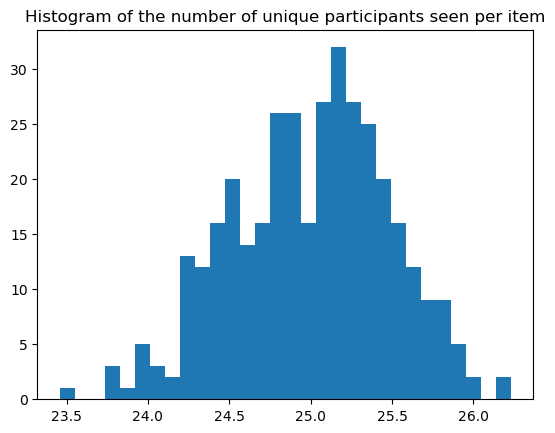

In [4]:
plt.hist(list(items_seen.values()), bins=30)
plt.title('Histogram of the number of unique participants seen per item')
plt.show()

In [5]:
from tqdm import tqdm

x = np.arange(20, 1000, 10)
y = np.arange(20, 1000, 10)
X,Y = np.meshgrid(x,y)

Z = np.empty_like(X)
with tqdm(total=len(x) * len(y), ncols=80) as prog:
    for i, (x_, y_) in enumerate(zip(X, Y)):
        for j, (x__, y__) in enumerate(zip(x_, y_)):
            tt, items_seen = estimate_total_time_taken(
              x__,
              y__,
              n_items_per_survey=17
            )
            cost = budget_estimate(tt)
            median_num_seen = np.median(list(items_seen.values()))
            Z[i, j] =median_num_seen
            prog.update()

100%|███████████████████████████████████████| 9604/9604 [02:24<00:00, 66.29it/s]


In [6]:
costs = []
condition = (Z == 25)
xx, yy = X[condition], Y[condition]
zz = np.array([25] * len(xx))
for x_, y_ in zip(xx, yy):
    tt, items_seen = estimate_total_time_taken(
      x_,
      y_,
      n_items_per_survey=17
    )
    cost = budget_estimate(tt)
    costs.append((x_, y_, cost))

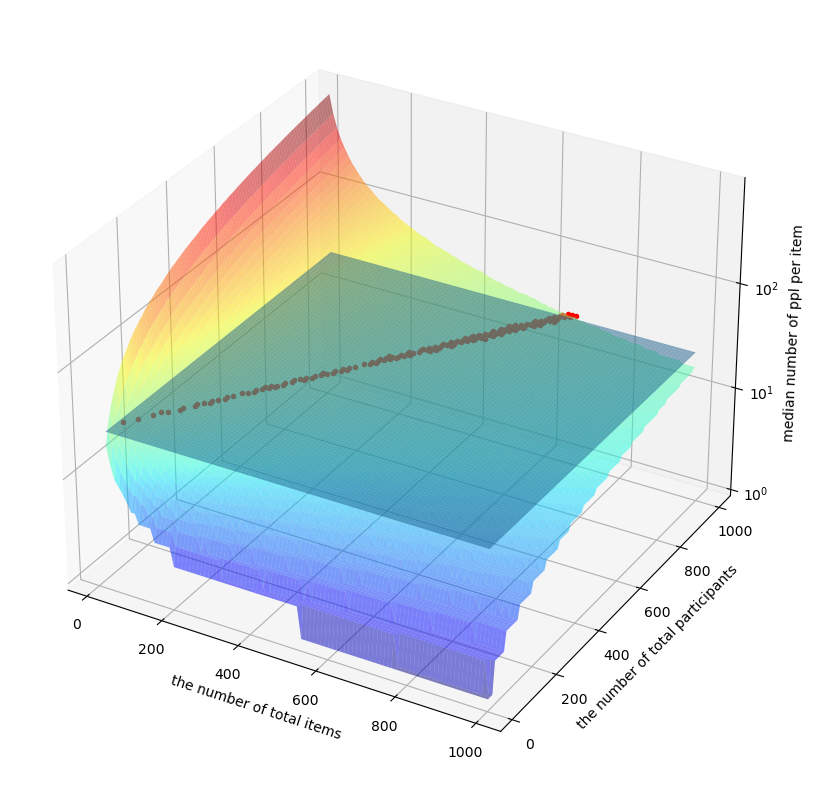

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.ticker as mticker


# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, np.log10(np.ones_like(Z) * 25), alpha=0.5, rstride=1, cstride=1)
ax.plot_surface(X, Y, np.log10(Z + 1), alpha=0.5, rstride=1, cstride=1, cmap=cm.jet)

ax.plot(xx, yy, np.log10(zz + 2), 'r.', alpha=1)

ax.set_xlabel('the number of total items')
ax.set_ylabel('the number of total participants')
ax.set_zlabel('median number of ppl per item')

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

plt.show()

In [8]:
import pandas as pd

costs_df = pd.DataFrame(costs, columns=['n_total_items', 'n_participants', 'est_cost'])

In [10]:
from pathlib import Path

cwd = Path.cwd()

file_path = (Path(cwd).parent / 'intermediary_data' / 'optimal_line.csv')

costs_df.to_csv(file_path)

In [16]:
conda env export > IX_participant_estimation_conda_environment.yml


Note: you may need to restart the kernel to use updated packages.


In [17]:
pip list --format=freeze > IX_participant_estimation_conda_pip_requirements.txt

Note: you may need to restart the kernel to use updated packages.
